[View in Colaboratory](https://colab.research.google.com/github/Leocodefocus/project/blob/master/features_cross.ipynb)

In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

In [0]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [0]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  selected_features = california_housing_dataframe[
      ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  processed_features["rooms_per_person"] = (
      california_housing_dataframe["total_rooms"]/
      california_housing_dataframe["population"])
  return processed_features

In [0]:
def preprocess_targets(california_housing_dataframe):
  processed_targets = pd.DataFrame()
  processed_targets["median_house_value"] = (
      california_housing_dataframe["median_house_value"]/1000.0)
  return processed_targets

In [15]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Taining targets summary:")
display.display(training_targets.describe())
print("Validation examples summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2639.8,537.8,1425.8,499.6,3.9,2.0
std,2.1,2.0,12.6,2201.3,421.1,1159.3,383.4,1.9,1.2
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1454.0,297.0,791.8,281.8,2.6,1.5
50%,34.2,-118.5,29.0,2128.0,433.0,1168.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3143.2,649.2,1725.0,606.0,4.8,2.3
max,42.0,-114.5,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2653.0,543.2,1438.6,505.1,3.9,2.0
std,2.2,2.0,12.6,2128.1,422.6,1119.9,387.3,1.8,1.1
min,32.5,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1474.0,296.0,786.0,282.0,2.6,1.5
50%,34.3,-118.5,28.0,2126.5,436.0,1164.0,409.0,3.5,2.0
75%,37.7,-118.0,37.0,3163.0,647.0,1715.2,603.0,4.8,2.3
max,41.9,-114.3,52.0,27700.0,4952.0,15037.0,4616.0,15.0,41.3


Taining targets summary:


,median_house_value
count,12000.0
mean,207.7
std,116.5
min,15.0
25%,119.4
50%,180.0
75%,265.9
max,500.0


Validation examples summary:


,median_house_value
count,5000.0
mean,206.4
std,114.9
min,22.5
25%,119.4
50%,180.9
75%,263.7
max,500.0


In [0]:
def construct_feature_column(input_features):
  return set([tf.feature_column.numeric_column(my_feature) 
              for my_feature in input_features])

In [0]:
def my_input_fn(features,targets,batch_size=1,shuffle=True,num_epochs=None):
  features = {key:np.array(value) for key,value in dict(features).items()}
  
  ds = Dataset.from_tensor_slices((features,targets))
  ds = ds.batch(batch_size).repeat(num_epochs)
  
  if shuffle:
    ds = ds.shuffle(10000)
  
  features,labels = ds.make_one_shot_iterator().get_next()
  return features,labels

In [0]:
def train_model(
    learning_rate,steps,batch_size,
    feature_columns,
    training_examples,training_targets,
    validation_examples,validation_targets):
  periods = 10
  steps_per_period = steps / periods
  
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns = feature_columns,
      optimizer=my_optimizer
  )
  
  training_input_fn = lambda:my_input_fn(training_examples,
                                         training_targets["median_house_value"])
  predict_training_input_fn = lambda:my_input_fn(training_examples,
                                                training_targets["median_house_value"],
                                                num_epochs=1,
                                                shuffle=False)
  predict_validation_input_fn = lambda:my_input_fn(validation_examples,
                                                  validation_targets["median_house_value"],
                                                  num_epochs=1,
                                                  shuffle=False)
  
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range(0,periods):
    linear_regressor.train(
        input_fn = training_input_fn,
        steps = steps_per_period
    )
    training_predictions = linear_regressor.predict(
        input_fn=predict_training_input_fn)
    training_predictions = np.array([item["predictions"][0] 
                                     for item in training_predictions])
    validation_predictions = linear_regressor.predict(
        input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item["predictions"][0] 
                                       for item in validation_predictions])
    
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions,training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions,validation_targets))
    
    print(" period %02d : %0.2f" % (period,training_root_mean_squared_error))
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")
  
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse,label="training")
  plt.plot(validation_rmse,label="validation")
  plt.legend()
  
  return linear_regressor
    
    

Training model...
RMSE (on training data):
 period 00 : 529.68
 period 01 : 261.22
 period 02 : 208.30
 period 03 : 200.74
 period 04 : 324.26
 period 05 : 240.91
 period 06 : 259.46
 period 07 : 199.15
 period 08 : 209.63
 period 09 : 227.37
Model training finished.


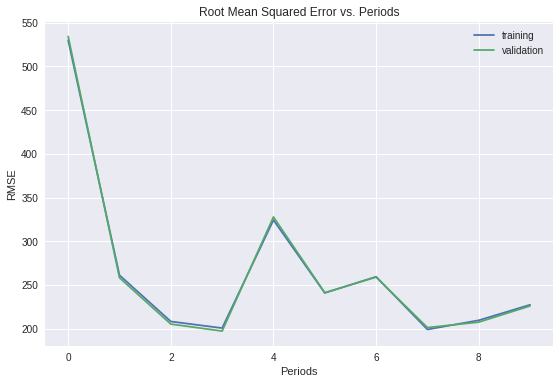

In [28]:
_ = train_model(
    learning_rate = 1.0,
    steps = 500,
    batch_size = 100,
    feature_columns = construct_feature_column(training_examples),
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets)